In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tables
import pandas as pd
import numpy as np
from toolz import memoize
from toise import plotting, surfaces, util, effective_areas, angular_resolution
import matplotlib as mpl
import photospline
from scipy import optimize
'''from autograd.misc.flatten import flatten_func
import autograd
import autograd.numpy as n'''
import os
import histlite 
import nuflux
import tables
import histlite as hl
#import warnings
#warnings.filterwarnings("ignore") # turn off warnings

In [2]:
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = mpl.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['legend.framealpha'] = 1
mpl.rc('font', size=16)

In [3]:
base_dir = '/home/steve/pone/data/'

In [4]:
f = tables.open_file(base_dir + '70_reco.hdf5')

In [5]:
len(f.root.I3EventHeader.cols.Event[:]) / 352.

32.0

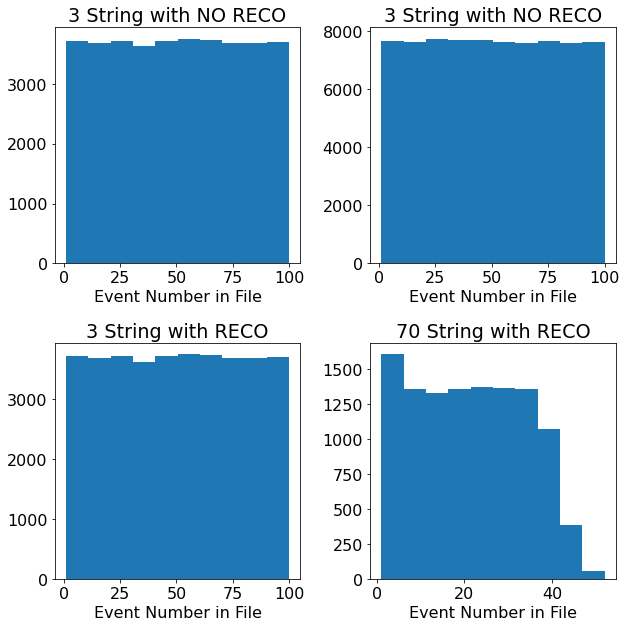

In [6]:
fig, axs = plt.subplots(2,2, figsize=(9,9))
f = tables.open_file(base_dir + '3_no_reco.hdf5')
ax = axs[0][0]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with NO RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '70_no_reco.hdf5')
ax = axs[0][1]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with NO RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '3_reco.hdf5')
ax = axs[1][0]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '70_reco.hdf5')
ax = axs[1][1]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('70 String with RECO')
ax.set_xlabel('Event Number in File')

plt.tight_layout()

In [7]:
def make_array(string, reco=True, nfiles=999, nevents=100):
    if reco:
         f = tables.open_file(base_dir + '{}_reco.hdf5'.format(string))
    else:
        f = tables.open_file(base_dir + '{}_no_reco.hdf5'.format(string))
    event = f.root.I3EventHeader.cols.Event[:]
    true_zenith = f.root.MCMuon.cols.zenith[:]
    true_azimuth = f.root.MCMuon.cols.azimuth[:]
    true_energy = f.root.MCMuon.cols.energy[:]
    area_weight = f.root.MuonEffectiveArea.cols.value[:]
    ow = 1e4*area_weight / (nfiles * nevents)
  
    w_astro = 1e-18 *ow *(true_energy/1e5)**-2
    w_atmo = 1e-18 *ow *(true_energy/1e5)**-3.7
    flux = nuflux.makeFlux('H3a_SIBYLL23C')
    nu_type=nuflux.NuMu
    nu_energy=true_energy # in GeV
    nu_cos_zenith = np.cos(true_zenith)
    w_h3a =2*ow* flux.getFlux(nu_type,nu_energy,nu_cos_zenith)

    if reco:
        lf_zen = f.root.linefit.cols.zenith[:]
        lf_azi = f.root.linefit.cols.azimuth[:]
        zen = f.root.LLHFit_cleaned_linefit_1_5.cols.zenith[:]
        azi = f.root.LLHFit_cleaned_linefit_1_5.cols.azimuth[:]
        array = np.vstack([event, true_zenith, true_azimuth, true_energy, area_weight, ow, w_astro, 
                           w_atmo, w_h3a, lf_zen, lf_azi, zen, azi] )
        
        df = pd.DataFrame(array.T, 
              columns=['event' , 'true_zenith', 'true_azimuth', 'true_energy', 'area_weight', 'ow', 'w_astro', 
                       'w_atmo', 'w_h3a',
                      'linefit_zenith', 'linefit_azimuth', 'zenith', 'azimuth'])
    else:
        array = np.vstack([event, true_zenith, true_azimuth, true_energy, area_weight, ow, w_astro, w_atmo, w_h3a])
        df = pd.DataFrame(array.T, 
                      columns=['event' , 'true_zenith', 'true_azimuth', 'true_energy', 'area_weight', 'ow', 
                               'w_astro','w_atmo', 'w_h3a'])
    return df

In [8]:
mc_w_reco = {}
strings = [3,10,70]
nfiles_reco = [997, 328, 352]
nevents = [100,100,32]
for i, string in enumerate(strings):
    mc_w_reco[string] = make_array(string, reco=True, nfiles=nfiles_reco[i], nevents=nevents[i])

In [9]:
mc_no_reco = {}
strings = [3,70]
nfiles_noreco = [999, 999]
for i, string in enumerate(strings):
    print(string)
    mc_no_reco[string] = make_array(string, reco=False, nfiles=nfiles_noreco[i])

3
70


In [10]:
#use the best of both 
mc = {}
mc[3] = mc_w_reco[3]
mc[10] = mc_w_reco[10]
mc[70] = mc_no_reco[70]

In [11]:
#rates
for string in [3,10,70]:
    print('----------')
    print('{} String : {:.2} Hz, Astro Events / year: {:.3}'.format(string, sum(mc[string].w_astro), 
                                                                     sum(mc[string].w_astro) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events (E^-3.7)/ year: {:.3}'.format(string, sum(mc[string].w_atmo), sum(mc[string].w_atmo) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events H3a / year: {:.3}'.format(string, sum(mc[string].w_h3a), 
                                                                        sum(mc[string].w_h3a) * 1 * 365 * 86400))

    print(' ')

----------
3 String : 0.0004 Hz, Astro Events / year: 1.25e+04
3 String : 0.29 Hz, Atmo Events (E^-3.7)/ year: 9.11e+06
3 String : 0.72 Hz, Atmo Events H3a / year: 2.28e+07
 
----------
10 String : 0.00074 Hz, Astro Events / year: 2.33e+04
10 String : 0.56 Hz, Atmo Events (E^-3.7)/ year: 1.75e+07
10 String : 1.4 Hz, Atmo Events H3a / year: 4.37e+07
 
----------
70 String : 0.0045 Hz, Astro Events / year: 1.41e+05
70 String : 3.8 Hz, Atmo Events (E^-3.7)/ year: 1.2e+08
70 String : 9.4 Hz, Atmo Events H3a / year: 2.97e+08
 


In [12]:
'''strings = [3,10,70]
nfiles = [997, 328, 352]
nevents = [100, 100, 32]
MC = {}
for i, string in enumerate(strings):
    dats = pd.read_csv("/home/steve/pone/scripts///data_toise_sensitivity_strippedreco_16pmts_{}string_geometry.csv".format(int(string)))
    dats['ow'] = dats['effective_area'] / (nfiles[i] * nevents[i])
    dats['true_zenith'] = dats['zenith_angle']
    dats['true_energy'] = dats['muon_energy']
    MC[string] = dats'''

'strings = [3,10,70]\nnfiles = [997, 328, 352]\nnevents = [100, 100, 32]\nMC = {}\nfor i, string in enumerate(strings):\n    dats = pd.read_csv("/home/steve/pone/scripts///data_toise_sensitivity_strippedreco_16pmts_{}string_geometry.csv".format(int(string)))\n    dats[\'ow\'] = dats[\'effective_area\'] / (nfiles[i] * nevents[i])\n    dats[\'true_zenith\'] = dats[\'zenith_angle\']\n    dats[\'true_energy\'] = dats[\'muon_energy\']\n    MC[string] = dats'

In [13]:
#aeffs is area_weight in units of GeV m^2 sr similar to oneweight 
# but oneweight is in terms of cm^2

In [14]:
def effa_plot_notlogged(ax, mc_dict, string=70, zen_deg_min = 0, zen_deg_max = 180, 
                        selection_eff = 1,label = 'MISC', color = 'k', ls = '-'):
    a = mc_dict[string]
    mask = (a.true_zenith < np.radians(zen_deg_max)) & (a.true_zenith > np.radians(zen_deg_min))
    
    dlogE=.1
    bins = 10**np.arange(3,6.01,dlogE)
    solid_angle=4*np.pi #2*np.pi*(np.cos(np.radians(zen_deg_min))) - np.cos(np.radians(zen_deg_max))
    area=  (1/(1e4*np.log(10)) * (a.ow[mask] / ( (a.true_energy[mask]) *  solid_angle *  dlogE)))
    #(1/1e4*np.log(10)) *
    h = hl.hist((a.true_energy[mask]), 
                #weights=dats.effective_area[mask] / (solid_angle * dlogE), 
                weights = selection_eff *area,
                bins=bins);
    hl.plot1d(h, histtype='step', linewidth=2, color=color, label=label, ls = ls, log=True)
    ax.loglog()

    ax.grid()
    #ax.legend(loc='lower right')
    ax.set_ylabel('$A_\mathsf{Eff}$($m^2$)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')

    #ax.set_xlim((10**2,10**7))
    #ax.set_ylim((1e-4,1e3))
    plt.tight_layout()
    return h

In [15]:
pstracks_hist = np.load('/home/steve/pone/data/pstracks_effa_all.hist.npy', allow_pickle=True)[()]
dnnc_hist = np.load('/home/steve/pone/data/DNNC_effa_all.hist.npy', allow_pickle=True)[()]
#pstracks_hist = np.load('/home/steve/pone/data/pstracks_effa_north.hist.npy', allow_pickle=True)[()]

In [16]:
selection_eff = .004/32

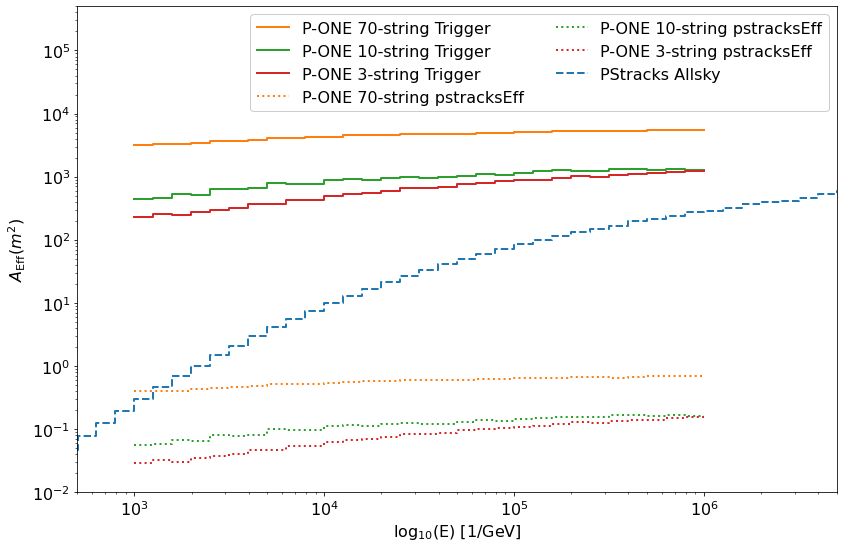

In [17]:
colors = ['C3', 'C1']
strings = [3,70]
fig,ax = plt.subplots(figsize=(12,8))

effa_plot_notlogged(ax, mc,  string= 70,label='P-ONE 70-string Trigger', color='C1', ls='-')
effa_plot_notlogged(ax, mc,   string = 10, label='P-ONE 10-string Trigger', color='C2', ls='-')
effa_plot_notlogged(ax, mc,   string = 3, label='P-ONE 3-string Trigger', color='C3', ls='-')

effa_plot_notlogged(ax, mc,selection_eff=selection_eff,  string= 70,label='P-ONE 70-string pstracksEff', color='C1', ls=':')
effa_plot_notlogged(ax, mc, selection_eff=selection_eff,  string = 10, label='P-ONE 10-string pstracksEff', color='C2', ls=":")
effa_plot_notlogged(ax, mc,  selection_eff=selection_eff, string = 3, label='P-ONE 3-string pstracksEff', color='C3', ls=':')

hl.plot1d(pstracks_hist, label='PStracks Allsky', c='C5', ls='--')
#hl.plot1d(dnnc_hist, label='DNNCascade Allsky', c='C6', ls='--')

plt.xlim(500,5e6)
plt.ylim(1e-2,5e5)
plt.legend(ncol=2)

In [18]:
#Effective Area / Geometric Area IceCube & Pone

In [19]:
def effa2d(string):
    d_logE = .1
    d_zen = 2 * np.pi * .1 
    a = mc[string]
    bins = (np.arange(3,6.01,d_logE), np.arange(-1,1,.1))

    area = (1/(1e4*np.log(10)) * (a.ow / (a.true_energy * d_zen * d_logE)))
    #range = [(-1,1), (3,6)]
    h2d = hl.hist((np.log10(a.true_energy), np.cos(a.true_zenith)),
                  weights=area,
                  bins=bins)
    return h2d

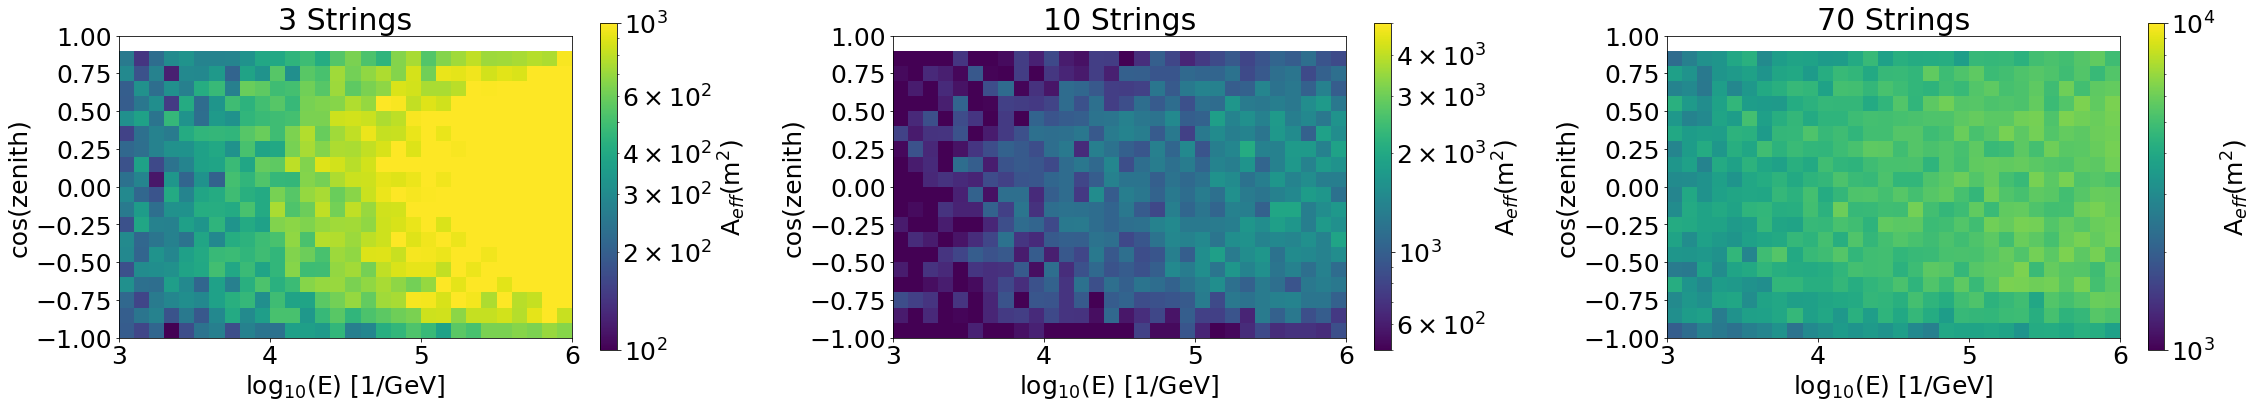

In [20]:
plt.rc('font', size=25)
fig, axs = plt.subplots(1,3, figsize=(32,6))
vmins = [1e2, 5e2, 1e3]
vmaxs=[1e3,5e3,1e4]
for i, string in enumerate([3,10,70]):
    ax = axs[i]
    h2d = effa2d(string)
    #fig, ax = plt.subplots()
    hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)',vmin=vmins[i],vmax=vmaxs[i], log=True)
    ax.set_yticks(np.arange(-1,1.01,.25))
    ax.set_ylabel('cos(zenith)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')
    ax.set_title('{} Strings'.format(string))
    ax.set_aspect('equal')
plt.tight_layout()